In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip 
!unzip bank.zip

--2025-09-17 15:16:10--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [   <=>              ] 999.85K  1.95MB/s    in 0.5s    

2025-09-17 15:16:12 (1.95 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


# Data preparation

In [13]:
df = pd.read_csv('bank-full.csv', delimiter=';')

df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
columns=['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'] # no 'default', 'loan'

categorical_columns = list(set(df.dtypes[(df.dtypes == 'object') & (df.columns != 'y')].index) & set(columns))
numerical_columns = list(set(df.dtypes[(df.dtypes != 'object') & (df.columns != 'y')].index) & set(columns))

In [25]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [26]:
df['y'] = (df['y']=='yes').astype(int)

df['y'].unique()

array([0, 1])

In [34]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

del df_train['y']
del df_val['y']
del df_test['y']

# Q1

In [35]:
from sklearn.metrics import roc_auc_score

variables = ['balance', 'day', 'duration', 'previous']
auc_values = {}

for v in variables:
    auc = roc_auc_score(y_train, df_train[v])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[v])

    auc_values[v]=auc

auc_values

{'balance': 0.5888313805382317,
 'day': 0.525957882383908,
 'duration': 0.8147002759670778,
 'previous': 0.5985653242764153}

# Q2

In [36]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [53]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_val = model.predict_proba(X_val)[:, 1]
round(roc_auc_score(y_val, y_pred_val),3)

0.9

In [54]:
y_pred_val, y_val

(array([0.0299613 , 0.02312939, 0.02077408, ..., 0.24828544, 0.00218739,
        0.03780662], shape=(9042,)),
 array([0, 0, 0, ..., 0, 0, 0], shape=(9042,)))

# Q3

/tmp/ipykernel_11850/4077645607.py:19: RuntimeWarning: invalid value encountered in scalar divide
  precisions.append(tp/(tp+fp))


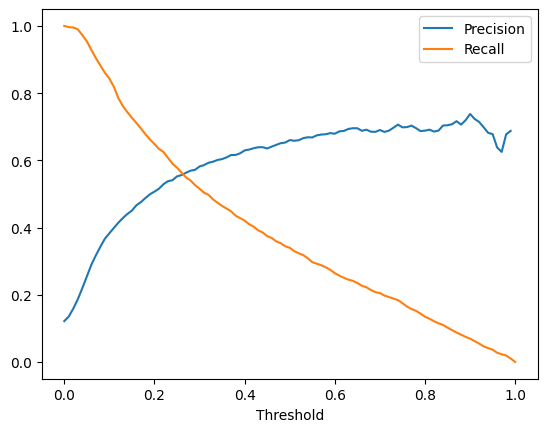

array([0.26])

In [59]:
thresholds = np.linspace(0,1, 101)

precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precisions.append(tp/(tp+fp))
    recalls.append(tp/(tp+fn))

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.show()

thresholds[np.where(np.abs(np.array(precisions)-np.array(recalls)) < 0.01)]

# Q4

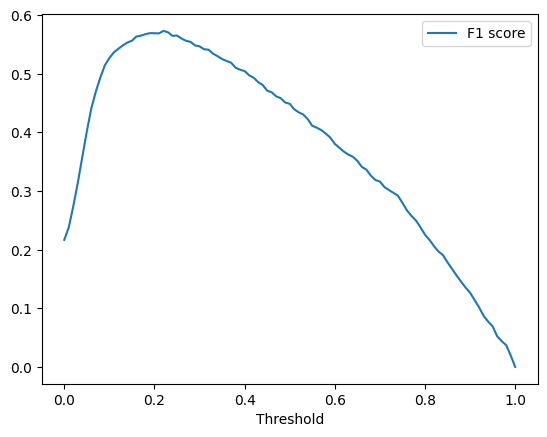

np.float64(0.22)

In [71]:
thresholds = np.linspace(0,1, 101)

f1_scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred_val >= t)
    predict_negative = (y_pred_val < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    precision = tp/(tp+fp) if (tp+fp)>0 else 0
    recall = tp/(tp+fn) if (tp+fn)>0 else 0

    f1_score = 2*precision*recall/(precision+recall) if precision + recall>0 else 0
    
    f1_scores.append(f1_score)

plt.plot(thresholds, f1_scores, label='F1 score')
plt.xlabel("Threshold")
plt.legend()
plt.show()

thresholds[np.argmax(np.array(f1_scores))]

# Q5


In [77]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [81]:
from sklearn.model_selection import KFold

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train['y'].values
    y_val = df_val['y'].values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

round(np.std(scores),3)

np.float64(0.006)

# Q6

In [82]:
n_splits = 5



for c in [0.000001, 0.001, 1]:

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['y'].values
        y_val = df_val['y'].values

        dv, model = train(df_train, y_train, C=c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C: {c}, mean: {round(np.mean(np.asarray(scores)), 3)}")


C: 1e-06, mean: 0.701
C: 0.001, mean: 0.861
C: 1, mean: 0.906
